# Analyzing Crime in Los Angeles

![Los Angeles skyline](la_skyline.jpg)

# Description

Los Angeles, California 😎. The City of Angels. Tinseltown. The Entertainment Capital of the World! 

Known for its warm weather, palm trees, sprawling coastline, and Hollywood, along with producing some of the most iconic films and songs. However, as with any highly populated city, it isn't always glamorous and there can be a large volume of crime.

I am analyzing data provided by the Los Angeles Police Department (LAPD) to identify patterns in criminal behavior. Such an analysis could be used to allocate resources effectively to tackle various crimes in different areas.

# The Data

This single dataset, `crimes.csv`, is a modified version of the original data, which is publicly available from Los Angeles Open Data.

## Column values

| Column     | Description              |
|------------|--------------------------|
| `'DR_NO'` | Division of Records Number: Official file number made up of a 2-digit year, area ID, and 5 digits. |
| `'Date Rptd'` | Date reported - MM/DD/YYYY. |
| `'DATE OCC'` | Date of occurrence - MM/DD/YYYY. |
| `'TIME OCC'` | In 24-hour military time. |
| `'AREA NAME'` | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, the 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles. |
| `'Crm Cd Desc'` | Indicates the crime committed. |
| `'Vict Age'` | Victim's age in years. |
| `'Vict Sex'` | Victim's sex: `F`: Female, `M`: Male, `X`: Unknown. |
| `'Vict Descent'` | Victim's descent:<ul><li>`A` - Other Asian</li><li>`B` - Black</li><li>`C` - Chinese</li><li>`D` - Cambodian</li><li>`F` - Filipino</li><li>`G` - Guamanian</li><li>`H` - Hispanic/Latin/Mexican</li><li>`I` - American Indian/Alaskan Native</li><li>`J` - Japanese</li><li>`K` - Korean</li><li>`L` - Laotian</li><li>`O` - Other</li><li>`P` - Pacific Islander</li><li>`S` - Samoan</li><li>`U` - Hawaiian</li><li>`V` - Vietnamese</li><li>`W` - White</li><li>`X` - Unknown</li><li>`Z` - Asian Indian</li> |
| `'Weapon Desc'` | Description of the weapon used (if applicable). |
| `'Status Desc'` | Crime status. |
| `'LOCATION'` | Street address of the crime. |

## Set up environment/get data

### Import Python Modules

In [1]:
# Add the project root to sys.path
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import HTML
from projectconfig.config import raw_data_path, crime_desc_table_new, crime_desc_table_orig, victim_sex_table

### Import data

### Get and set helper values

In [3]:
default_rows = pd.get_option('display.max_rows')

In [4]:
crimes = pd.read_csv(raw_data_path, date_format='%m/%d/%Y %I:%M:%S %p', parse_dates=["Date Rptd", "DATE OCC"], dtype={"TIME OCC": str})
crimes.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,221412410,2022-06-15,2020-11-12,1700,Pacific,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0,NaN,NaN,NaN,Invest Cont,13600 MARINA POINT DR
1,220314085,2022-07-22,2020-05-12,1110,Southwest,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
2,222013040,2022-08-06,2020-06-04,1620,Olympic,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST
3,220614831,2022-08-18,2020-08-17,1200,Hollywood,THEFT OF IDENTITY,28,M,H,NaN,Invest Cont,1900 TRANSIENT
4,231207725,2023-02-27,2020-01-27,0635,77th Street,THEFT OF IDENTITY,37,M,H,NaN,Invest Cont,6200 4TH AV


# Data cleaning

##### *Rename columns*

In [5]:
columns = {
    'DR_NO': 'dr_no',
    'Date Rptd': 'date_reported',
    'DATE OCC': 'date_occured',
    'TIME OCC': 'time_occured',
    'AREA NAME': 'area',
    'Crm Cd Desc': 'crime_description',
    'Mocodes': 'mo_codes',
    'Vict Age': 'victim_age',
    'Vict Sex': 'victim_sex',
    'Vict Descent': 'victim_descent',
    'Premis Desc': 'premises_description',
    'Weapon Desc': 'weapon_description',
    'Status Desc': 'crime_status',
    'LOCATION': 'location',
    'LAT': 'latitude',
    'LON': 'longitude'
}
crimes.rename(columns=columns, inplace=True)
crimes.columns

Index(['dr_no', 'date_reported', 'date_occured', 'time_occured', 'area',
       'crime_description', 'victim_age', 'victim_sex', 'victim_descent',
       'weapon_description', 'crime_status', 'location'],
      dtype='object')

##### *Check data types*

In [15]:
crimes.dtypes

dr_no                            int64
date_reported           datetime64[ns]
date_occured            datetime64[ns]
time_occured                    object
area                            object
crime_description               object
mo_codes                        object
victim_age                       int64
victim_sex                      object
victim_descent                  object
premises_description            object
weapon_description              object
crime_status                    object
location                        object
latitude                       float64
longitude                      float64
dtype: object

##### *Check for null values*

In [16]:
crimes.isnull().sum()

dr_no                        0
date_reported                0
date_occured                 0
time_occured                 0
area                         0
crime_description            0
mo_codes                151705
victim_age                   0
victim_sex              144729
victim_descent          144741
premises_description       588
weapon_description      677841
crime_status                 0
location                     0
latitude                     0
longitude                    0
dtype: int64

##### *Check column values*

###### Area names

In [17]:
np.sort(crimes.area.unique())

array(['77th Street', 'Central', 'Devonshire', 'Foothill', 'Harbor',
       'Hollenbeck', 'Hollywood', 'Mission', 'N Hollywood', 'Newton',
       'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast',
       'Southwest', 'Topanga', 'Van Nuys', 'West LA', 'West Valley',
       'Wilshire'], dtype=object)

###### Crime description

In [18]:
cd = pd.DataFrame(np.sort(crimes.crime_description.unique()), columns=['crime_description'])
cd.to_markdown(crime_desc_table_orig, index=False)

# Fix comma spacing
crimes.crime_description = crimes.crime_description.replace(r', *', ', ', regex=True)

# Fix slash spacing
crimes.crime_description = crimes.crime_description.replace(r' */ *', '/', regex=True)

# Match formatting for grand and petty theft
crimes.crime_description = crimes.crime_description.replace('DEFRAUDING INNKEEPER/THEFT OF SERVICES, OVER $950.01', 'DEFRAUDING INNKEEPER/THEFT OF SERVICES ($950.01 & OVER)')

crimes.crime_description = crimes.crime_description.replace('DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER', 'DEFRAUDING INNKEEPER/THEFT OF SERVICES ($950 & UNDER)')

crimes.crime_description = crimes.crime_description.replace('CREDIT CARDS, FRAUD USE ($950 & UNDER', 'CREDIT CARDS, FRAUD USE ($950 & UNDER)')

crimes.crime_description = crimes.crime_description.replace('REPLICA FIREARMS(SALE, DISPLAY, MANUFACTURE OR DISTRIBUTE)', 'REPLICA FIREARMS (SALE, DISPLAY, MANUFACTURE OR DISTRIBUTE)')

crimes.crime_description = crimes.crime_description.replace('THEFT-GRAND ($950.01 & OVER)EXCPT, GUNS, FOWL, LIVESTK, PROD', 'THEFT - GRAND ($950.01 & OVER) EXCEPT GUNS, FOWL, LIVESTOCK, PRODUCE')

crimes.crime_description = crimes.crime_description.replace('DISHONEST EMPLOYEE ATTEMPTED THEFT', 'DISHONEST EMPLOYEE - ATTEMPTED THEFT')

crimes.crime_description = crimes.crime_description.replace('SEX, UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/FRGN OBJ', 'SEX, UNLAWFUL(INCLUDING MUTUAL CONSENT, PENETRATION W/FOREIGN OBJECT)')

crimes.crime_description = crimes.crime_description.replace('SHOPLIFTING-GRAND THEFT ($950.01 & OVER)', 'SHOPLIFTING - GRAND THEFT ($950.01 & OVER)')

crimes.crime_description = crimes.crime_description.replace('SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH', 'SODOMY/SEXUAL CONTACT BY OR WITH PENIS OF ONE PERSON TO ANUS OF OTHER')

cd = pd.DataFrame(np.sort(crimes.crime_description.unique()), columns=['crime_description'])
cd.to_markdown(crime_desc_table_new, index=False)

###### Victim age

In [19]:
np.sort(crimes.victim_age.unique())
crimes.loc[crimes.victim_age < 0, ['victim_age', 'crime_description']].sort_values('victim_age')

,victim_age,crime_description
7448,-4,"BUNCO, GRAND THEFT"
52784,-4,BATTERY ON A FIREFIGHTER
159279,-4,"BUNCO, GRAND THEFT"
31167,-3,THEFT PLAIN - PETTY ($950 & UNDER)
28070,-3,THEFT OF IDENTITY
...,...,...
973965,-1,THEFT PLAIN - PETTY ($950 & UNDER)
975884,-1,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE
975934,-1,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)"
980745,-1,THEFT PLAIN - PETTY ($950 & UNDER)


###### Victim sex

In [20]:
pd.DataFrame(crimes.loc[crimes.victim_sex == 'H']).to_markdown(victim_sex_table) # View records visually to search for patterns
# crimes.victim_sex = crimes.victim_sex.replace({'M': 'male', 'F': 'female', 'X': 'unknown', 'H': 'unknown_1', '-': 'unknown_2'})
crimes.victim_sex.value_counts()

victim_sex
M    403888
F    358582
X     97777
H       114
-         1
Name: count, dtype: int64

###### Victim descent

In [11]:
crimes.victim_descent.value_counts()

victim_descent
H    296408
W    201443
B    135818
X    106689
O     78009
A     21340
K      5990
F      4838
C      4631
J      1586
V      1195
I      1015
Z       577
P       288
U       221
D        91
L        77
G        74
S        58
-         2
Name: count, dtype: int64

# Exploratory analysis

*Get counts of all unique values in columsn that are not date, time or index*

In [12]:
for col in columns.values():
    if not re.search('date|time|dr_no', col):
        display(crimes[col].value_counts())

area
Central        69670
77th Street    61758
Pacific        59521
Southwest      57513
Hollywood      52429
N Hollywood    51107
Olympic        50071
Southeast      49936
Newton         49177
Wilshire       48239
Rampart        46825
West LA        45731
Northeast      42962
Van Nuys       42883
West Valley    42158
Devonshire     41761
Harbor         41402
Topanga        41375
Mission        40352
Hollenbeck     37085
Foothill       33136
Name: count, dtype: int64

crime_description
VEHICLE - STOLEN                                           115239
BATTERY - SIMPLE ASSAULT                                    74839
BURGLARY FROM VEHICLE                                       63518
THEFT OF IDENTITY                                           62539
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     61092
                                                            ...  
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)              5
FIREARMS RESTRAINING ORDER (FIREARMS RO)                        4
DISHONEST EMPLOYEE - ATTEMPTED THEFT                            4
TRAIN WRECKING                                                  1
DRUNK ROLL - ATTEMPT                                            1
Name: count, Length: 140, dtype: int64

mo_codes
0344                                  42195
0329                                  21630
1822 0344                             14248
0325                                  10278
0344 1822                              9840
                                      ...  
2000 0400 0416 0444 1814 0906             1
0602 0329 0554 0913 1402 2004             1
0319 0334 0400 0443 1814 2000             1
1822 1309 0421 0919 0334 0400             1
0342 1309 0334 0302 0421 1312 1822        1
Name: count, Length: 310939, dtype: int64

victim_age
 0      269313
 30      22289
 35      21836
 31      21420
 29      21345
         ...  
 98         71
-2          28
-3           6
-4           3
 120         1
Name: count, Length: 104, dtype: int64

victim_sex
M    403888
F    358582
X     97777
H       114
-         1
Name: count, dtype: int64

victim_descent
H    296408
W    201443
B    135818
X    106689
O     78009
A     21340
K      5990
F      4838
C      4631
J      1586
V      1195
I      1015
Z       577
P       288
U       221
D        91
L        77
G        74
S        58
-         2
Name: count, dtype: int64

premises_description
STREET                                          261348
SINGLE FAMILY DWELLING                          163658
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    119012
PARKING LOT                                      69154
OTHER BUSINESS                                   47648
                                                 ...  
DEPT OF DEFENSE FACILITY                             2
MTA - SILVER LINE - DOWNTOWN STREET STOPS            2
HORSE RACING/SANTA ANITA PARK*                       2
MTA - SILVER LINE - LAC/USC MEDICAL CENTER           2
TRAM/STREETCAR(BOXLIKE WAG ON RAILS)*                1
Name: count, Length: 306, dtype: int64

weapon_description
STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    174764
UNKNOWN WEAPON/OTHER WEAPON                        36390
VERBAL THREAT                                      23846
HAND GUN                                           20182
SEMI-AUTOMATIC PISTOL                               7267
                                                   ...  
MAC-11 SEMIAUTOMATIC ASSAULT WEAPON                    3
HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE          2
M-14 SEMIAUTOMATIC ASSAULT RIFLE                       2
MAC-10 SEMIAUTOMATIC ASSAULT WEAPON                    2
M1-1 SEMIAUTOMATIC ASSAULT RIFLE                       1
Name: count, Length: 79, dtype: int64

crime_status
Invest Cont     803306
Adult Other     109603
Adult Arrest     87031
Juv Arrest        3271
Juv Other         1873
UNK                  7
Name: count, dtype: int64

location
800 N  ALAMEDA                      ST      2598
700 S  FIGUEROA                     ST      1711
100    THE GROVE                    DR      1688
10200    SANTA MONICA                 BL    1657
6TH                          ST             1585
                                            ... 
LOMA VERDE                   ST                1
4500    FORMAN                       AV        1
13700    AMANDA                       LN       1
LORD                         ST                1
21000    SAN JOSE                     ST       1
Name: count, Length: 66566, dtype: int64

latitude
34.1016    5705
34.2012    4506
34.0980    4265
34.1939    3544
34.1867    3299
           ... 
33.8628       1
33.7498       1
34.3260       1
33.7661       1
33.8366       1
Name: count, Length: 5426, dtype: int64

longitude
-118.2739    7550
-118.2827    6434
-118.2915    4297
-118.2652    4257
-118.2871    3923
             ... 
-118.6586       1
-118.6317       1
-118.1663       1
-118.1594       1
-118.6024       1
Name: count, Length: 4982, dtype: int64

## Finding the frequencies of crimes by the hour of occurrence

In [13]:
hours = crimes.loc[:, 'TIME OCC'].str[:2].astype(int)
crimes['HOUR OCC'] = hours
sns.histplot(hours)
plt.show()
peak_crime_hour = 12
print(f'Peak crime hour: {peak_crime_hour}')

KeyError: 'TIME OCC'

## Identifying the area with the most night crime

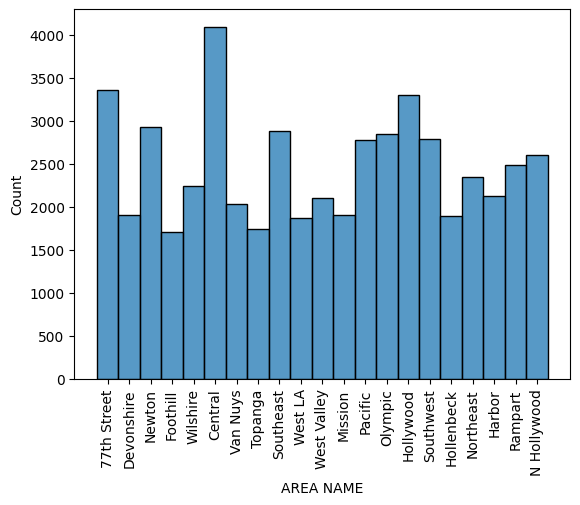

Peak night crime location: Central


In [ ]:
hr_ranges = [x for x in range(4)] + [y for y in range(22, 24)]
night_crimes = crimes[crimes['HOUR OCC'].isin(hr_ranges)]
night_crimes
sns.histplot(night_crimes['AREA NAME'])
plt.xticks(rotation=90)
plt.show()
night_crime_counts = night_crimes['AREA NAME'].value_counts()
peak_night_crime_location = 'Central'
print(f'Peak night crime location: {peak_night_crime_location}')

## Crimes by age group

In [ ]:
labels=['<18', '18-25', '26-34', '35-44', '45-54', '55-64', '65+']
bins = [0, 17, 25, 34, 44, 54, 64, np.inf]
crimes['AGE GROUP'] = pd.cut(crimes['Vict Age'], bins=bins, labels=labels)
victim_ages = crimes['AGE GROUP'].value_counts()
for i in victim_ages.index:
    print(f'Number of victims aged {i}: {victim_ages[i]}')

Number of victims aged 26-34: 47470
Number of victims aged 35-44: 42157
Number of victims aged 45-54: 28353
Number of victims aged 18-25: 28291
Number of victims aged 55-64: 20169
Number of victims aged 65+: 14747
Number of victims aged <18: 4528
